# Topic Modelling example
## Following a tutorial and explanation of Topic Modelling
<br/>

### Importing Packages and the Dataset:
To start, some importing needs to be done,
this includes; a list of stopwords, newsgroup(online forum) dataset, lemmatization tools, Gensim, and others.
<br/>

In [9]:
import nltk;
nltk.download('stopwords')

#using the natural language toolkit to download a list of stopwords e.g.

#-these are words that don't hold any topic or meaning
#and are only useful for putting together a sentance

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#importing packages that will be used later

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'ax'])

In [10]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

#dowloading the newsgroups dataset to use later for clustering into topics
#-the first few lines of this data are shown below;

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


### Preparing the data:
the data has to be reformatted and filtered to build a working topic model
<br/>

In [11]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

#overall, this simplifies the data into a more usable format,
#by removing unnecessary text like emails or formatting code

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

#this removes punctuation like commas or dots from the list
#and converts it into individual words

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

#a bigram is a combiation of two words that are commonly written together,
#a trigram is the same but with 3 words etc.

#this code defines what is considered as a bigram
#using parameters like minimum count,
#(the minimum number of times a given combination of words must appear
#in the text to be considered a bigram)
#or threshold

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatisation(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    #*
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#*lemmatisation is the abstactification of words into their root form
#e.g running or ran both become run

#this defines functions to lemmitise, remove stopwords from and
# make bigrams and trigrams from the dataset

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatised = lemmatisation(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatised[:1])

#applies the previous functions to the dataset

[['s', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatised)

# Create Corpus
texts = data_lemmatised

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

#creates dictionary and corpus to filter out names
#and other unrecognised text not included in the english dictionary
#from the list of words

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


## Building the Topic Model
All the preperation is finished and now the LDA model can be made.
<br/>

In [26]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [37]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"say" + 0.018*"think" + 0.018*"people" + 0.017*"go" + 0.016*"make" + '
  '0.015*"know" + 0.014*"see" + 0.011*"come" + 0.011*"well" + 0.011*"thing"'),
 (1,
  '0.069*"team" + 0.065*"game" + 0.045*"play" + 0.040*"win" + 0.036*"year" + '
  '0.032*"player" + 0.023*"run" + 0.020*"hit" + 0.017*"trade" + 0.017*"score"'),
 (2,
  '0.084*"drug" + 0.048*"proof" + 0.046*"terrorism" + 0.034*"blind" + '
  '0.031*"homosexual" + 0.028*"economic" + 0.028*"rise" + 0.028*"percent" + '
  '0.019*"investigation" + 0.018*"whole"'),
 (3,
  '0.068*"wing" + 0.053*"signal" + 0.042*"circuit" + 0.030*"dual" + '
  '0.028*"cap" + 0.027*"fuel" + 0.027*"laboratory" + 0.025*"floor" + '
  '0.024*"pointer" + 0.023*"travel"'),
 (4,
  '0.030*"car" + 0.023*"buy" + 0.021*"get" + 0.020*"good" + 0.020*"price" + '
  '0.018*"sell" + 0.017*"sale" + 0.017*"d" + 0.016*"cost" + 0.015*"pay"'),
 (5,
  '0.045*"kill" + 0.031*"child" + 0.027*"war" + 0.025*"death" + 0.024*"attack" '
  '+ 0.024*"soldier" + 0.022*"armenian" + 0

In [38]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatised, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.822949202133325

Coherence Score:  0.48517145463712097


In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\tobia\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.332668 -0.064577       1        1  34.044845
15     0.278534 -0.115060       2        1  15.579944
13     0.268648  0.116071       3        1  10.753444
10     0.196969  0.214021       4        1   8.864493
16     0.153587 -0.070255       5        1   6.113288
4      0.199523  0.059822       6        1   5.936222
14     0.097198  0.152741       7        1   4.078034
1      0.071011 -0.063878       8        1   2.780606
18     0.011976 -0.240043       9        1   2.689745
5      0.005528 -0.235304      10        1   2.392542
19    -0.025594  0.105884      11        1   1.782725
8     -0.126765  0.025182      12        1   1.165676
11    -0.144522  0.008202      13        1   0.728169
7     -0.161255  0.020881      14        1   0.724318
17    -0.180792  0.008198      15        1   0.555415
2     -0.182269  0.019439      16        1   0.470639
3     -0.183684  0.016503      17        1   0.446942
9     -0.197220  0.015223      18        1   0.370099
6     -0.208052  0.013780      19        1   0.276437
12    -0.205490  0.013171      20        1   0.246419, topic_info=               Term          Freq         Total Category  logprob  loglift
17             line  16364.000000  16364.000000  Default  30.0000  30.0000
206           write  13252.000000  13252.000000  Default  29.0000  29.0000
143    organization   8782.000000   8782.000000  Default  28.0000  28.0000
44          article   9455.000000   9455.000000  Default  27.0000  27.0000
24       nntp_poste   6653.000000   6653.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
8181         deeply      0.034494      1.219252  Topic20 -11.3725   2.4407
11228          bend      0.034494      1.219260  Topic20 -11.3725   2.4407
4981          clone      0.034494      1.219272  Topic20 -11.3725   2.4407
5490        uranium      0.034492      1.219237  Topic20 -11.3726   2.4406
3892          slave      0.034495      1.219421  Topic20 -11.3725   2.4406

[891 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
86        3  0.045072    access
86        7  0.953791    access
622       5  0.998446  activity
183       3  0.999528   address
3138     14  0.985939    adjust
...     ...       ...       ...
206       4  0.780695     write
472       1  0.999014     wrong
39        2  0.754214      year
39        8  0.245577      year
2594      9  0.995883      zone

[1164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 16, 14, 11, 17, 5, 15, 2, 19, 6, 20, 9, 12, 8, 18, 3, 4, 10, 7, 13])

In [40]:
# Build LDA model
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# Print the Keyword in the 10 topics
pprint(lda_model2.print_topics())
doc_lda2 = lda_model2[corpus]

[(0,
  '0.019*"say" + 0.017*"people" + 0.010*"think" + 0.010*"make" + '
  '0.008*"believe" + 0.008*"know" + 0.008*"many" + 0.008*"see" + '
  '0.008*"reason" + 0.007*"point"'),
 (1,
  '0.036*"team" + 0.034*"game" + 0.026*"year" + 0.024*"play" + 0.021*"win" + '
  '0.017*"player" + 0.012*"hockey" + 0.010*"run" + 0.009*"lose" + '
  '0.009*"trade"'),
 (2,
  '0.016*"kill" + 0.014*"war" + 0.014*"israeli" + 0.013*"soldier" + '
  '0.012*"attack" + 0.012*"armenian" + 0.012*"existence" + 0.012*"child" + '
  '0.011*"village" + 0.011*"greek"'),
 (3,
  '0.053*"internet" + 0.033*"item" + 0.026*"food" + 0.025*"material" + '
  '0.024*"recommend" + 0.023*"eat" + 0.021*"upgrade" + 0.013*"oil" + '
  '0.013*"cap" + 0.013*"specify"'),
 (4,
  '0.044*"line" + 0.031*"write" + 0.028*"get" + 0.026*"organization" + '
  '0.024*"article" + 0.020*"nntp_poste" + 0.018*"go" + 0.015*"host" + '
  '0.015*"m" + 0.014*"know"'),
 (5,
  '0.060*"law" + 0.039*"state" + 0.037*"government" + 0.024*"right" + '
  '0.019*"protect" 

In [42]:
# Compute Perplexity
print('\nPerplexity: ', lda_model2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=lda_model2, texts=data_lemmatised, dictionary=id2word, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Perplexity:  -10.122437187911329

Coherence Score:  0.4892923793001985


In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model2, corpus, id2word)
vis

C:\Users\tobia\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.280871  0.129220       1        1  31.567273
4     -0.287909  0.112308       2        1  24.466920
10    -0.226439 -0.121729       3        1  12.808926
9     -0.063377 -0.294850       4        1   6.414160
8     -0.005768 -0.069163       5        1   5.998420
11    -0.020635 -0.168575       6        1   5.471254
1     -0.022335  0.156725       7        1   4.513974
2      0.042356  0.174261       8        1   3.861123
5      0.172612  0.073782       9        1   2.222810
3      0.226916 -0.006800      10        1   1.151633
7      0.229067  0.010423      11        1   0.779708
6      0.236382  0.004399      12        1   0.743800, topic_info=               Term          Freq         Total Category  logprob  loglift
17             line  15099.000000  15099.000000  Default  30.0000  30.0000
130               m   4889.000000   4889.000000  Default  29.0000  29.0000
206           write  11961.000000  11961.000000  Default  28.0000  28.0000
143    organization   8050.000000   8050.000000  Default  27.0000  27.0000
113             get   9117.000000   9117.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
3473         buffer     64.874665     65.947200  Topic12  -4.9378   4.8848
2026        segment     63.068214     64.140750  Topic12  -4.9661   4.8843
4105          sleep     61.163104     62.235658  Topic12  -4.9967   4.8838
12434        column     59.761849     60.834389  Topic12  -5.0199   4.8834
6138       numerous     56.541616     57.614172  Topic12  -5.0753   4.8824

[584 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4326     11  0.997549           _
4195      5  0.953412     ability
4195      7  0.045043     ability
1342      1  0.998758      accept
5567      9  0.994571  acceptable
...     ...       ...         ...
39        5  0.083938        year
39        6  0.086336        year
39        7  0.347264        year
39        8  0.054200        year
5283     12  0.990634       youth

[844 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 11, 10, 9, 12, 2, 3, 6, 4, 8, 7])

In [17]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = r'C:\Users\tobia\Downloads\mallet-2.0.8\mallet-2.0.8\bin\mallet'

import os
os.environ['MALLET_HOME'] = r'C:\Users\tobia\Downloads\mallet-2.0.8\mallet-2.0.8'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatised, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(4,
  [('people', 0.017029717124425938),
   ('armenian', 0.01340219081145798),
   ('war', 0.010149925841210843),
   ('israeli', 0.009345794392523364),
   ('kill', 0.008881185111059488),
   ('attack', 0.008362967066349779),
   ('government', 0.008273619127606727),
   ('turkish', 0.007844749021640071),
   ('land', 0.0074158789156734154),
   ('state', 0.006629617054734548)]),
 (16,
  [('file', 0.03422857142857143),
   ('window', 0.029085714285714284),
   ('program', 0.016685714285714286),
   ('line', 0.015828571428571428),
   ('set', 0.013085714285714286),
   ('problem', 0.011561904761904761),
   ('entry', 0.009885714285714286),
   ('change', 0.009561904761904761),
   ('read', 0.008628571428571428),
   ('error', 0.008323809523809523)]),
 (10,
  [('make', 0.02221165105386417),
   ('year', 0.01988802693208431),
   ('work', 0.017710772833723652),
   ('money', 0.01527737119437939),
   ('people', 0.013136709601873537),
   ('pay', 0.012313378220140515),
   ('job', 0.011032640515222483),
   ('c

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatised, start=2, limit=40, step=6)

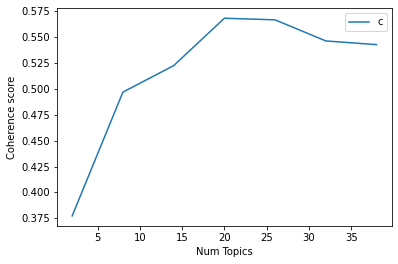

In [22]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3773
Num Topics = 8  has Coherence Value of 0.4968
Num Topics = 14  has Coherence Value of 0.5224
Num Topics = 20  has Coherence Value of 0.5682
Num Topics = 26  has Coherence Value of 0.5666
Num Topics = 32  has Coherence Value of 0.5463
Num Topics = 38  has Coherence Value of 0.5427


In [24]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.014*"armenian" + 0.013*"people" + 0.010*"war" + 0.009*"israeli" + '
  '0.008*"government" + 0.008*"attack" + 0.008*"turkish" + 0.008*"kill" + '
  '0.007*"land" + 0.007*"world"'),
 (1,
  '0.022*"people" + 0.013*"day" + 0.013*"child" + 0.012*"woman" + '
  '0.011*"start" + 0.011*"man" + 0.011*"happen" + 0.010*"live" + 0.009*"fire" '
  '+ 0.009*"home"'),
 (2,
  '0.027*"gun" + 0.021*"law" + 0.018*"state" + 0.014*"people" + 0.010*"crime" '
  '+ 0.009*"case" + 0.009*"weapon" + 0.008*"firearm" + 0.008*"police" + '
  '0.006*"criminal"'),
 (3,
  '0.025*"mail" + 0.024*"information" + 0.022*"send" + 0.021*"post" + '
  '0.019*"list" + 0.018*"group" + 0.018*"address" + 0.017*"internet" + '
  '0.014*"message" + 0.014*"email"'),
 (4,
  '0.133*"write" + 0.097*"article" + 0.050*"line" + 0.025*"thing" + '
  '0.025*"organization" + 0.023*"make" + 0.022*"hear" + 0.019*"ve" + '
  '0.018*"good" + 0.014*"opinion"'),
 (5,
  '0.011*"drug" + 0.010*"science" + 0.010*"study" + 0.009*"food" + '
  '0.008*"

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
  
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\tobia\AppData\Local\Temp\ipykernel_14776\2479197559.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\tobia\AppData\Local\Temp\ipykernel_14776\2479197559.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10,0.1986,"car, bike, ride, drive, article, engine, road,...",From: (wheres my thing) Subject: WHAT car is t...
1,1,12,0.1571,"bit, run, problem, line, work, monitor, color,...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,12,0.1405,"bit, run, problem, line, work, monitor, color,...",From: (Thomas E Willis) Subject: PB questions....
3,3,9,0.0967,"line, nntp_poste, organization, host, write, a...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,4,0.1048,"write, article, line, thing, organization, mak...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,2,0.3647,"gun, law, state, people, crime, case, weapon, ...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,5,0.1104,"drug, science, study, food, effect, doctor, di...",From: (brian manning delaney) Subject: Brain T...
7,7,13,0.4314,"drive, card, driver, scsi, system, disk, pc, w...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,16,0.1398,"file, program, window, image, version, applica...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,13,0.1445,"drive, card, driver, scsi, system, disk, pc, w...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Num', "Perc", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Num,Perc,Keywords,Text
0,0,0.7386,"armenian, people, war, israeli, government, at...",From: Center for Policy Research Subject: Fina...
1,1,0.8140,"people, day, child, woman, start, man, happen,...",From: (David Davidian) Subject: Accounts of An...
2,2,0.6898,"gun, law, state, people, crime, case, weapon, ...",From: (Larry Cipriani) Subject: Ohio House Bil...
3,3,0.6042,"mail, information, send, post, list, group, ad...",From: (Robert Lipman) Subject: CALL FOR PRESEN...
4,4,0.4287,"write, article, line, thing, organization, mak...",From: (Christopher Lusardi) Subject: Program I...
5,5,0.6982,"drug, science, study, food, effect, doctor, di...","From: Subject: Candida(yeast) Bloom, Fact or F..."
6,6,0.7967,"game, team, year, play, player, win, good, sea...",From: (Rocket) Subject: NHL Final point standi...
7,7,0.6562,"book, read, question, find, point, give, time,...",From: (Dave Butler) Subject: Re: NEW BIBLICAL ...
8,8,0.8938,"key, encryption, system, government, technolog...",From: (Clipper Chip Announcement) Subject: tex...
9,9,0.4119,"line, nntp_poste, organization, host, write, a...",From: (Brian Dealy - CSC) Subject: Re: XWindow...


In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,10,"car, bike, ride, drive, article, engine, road,...",493.0,0.0436
1,12,"bit, run, problem, line, work, monitor, color,...",289.0,0.0255
2,12,"bit, run, problem, line, work, monitor, color,...",531.0,0.0469
3,9,"line, nntp_poste, organization, host, write, a...",385.0,0.0340
4,4,"write, article, line, thing, organization, mak...",268.0,0.0237
...,...,...,...,...
11309,5,"drug, science, study, food, effect, doctor, di...",NaN,NaN
11310,12,"bit, run, problem, line, work, monitor, color,...",NaN,NaN
11311,12,"bit, run, problem, line, work, monitor, color,...",NaN,NaN
11312,7,"book, read, question, find, point, give, time,...",NaN,NaN


In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

AttributeError: 'LdaMallet' object has no attribute 'inference'